In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from SpatialFusion import SpatialFusion


In [3]:
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# the location of R, which is necessary for mclust algorithm. Please replace the path below with local R installation path
os.environ['R_HOME'] = '/usr/lib/R'

In [5]:
# read data
dataset = '151673'
file_fold = '/data/GraphCVAE/data/DLPFC/' + str(dataset) #please replace 'file_fold' with the download path
adata = sc.read_visium(file_fold, count_file='filtered_feature_bc_matrix.h5', load_images=True)
adata.var_names_make_unique()

/root/anaconda3/envs/deepst_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/root/anaconda3/envs/deepst_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [7]:
# define model
model = SpatialFusion.SpatialFusion(adata, device=device,epochs=1000,random_seed=1999)

In [8]:
# train model
adata = model.train()

  0%|          | 0/1000 [00:00<?, ?it/s]

Begin to train ST data...


/root/anaconda3/envs/deepst_env/lib/python3.9/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/data/SpatialFusion-main/SpatialFusion/model.py:74: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.alpha = F.softmax(torch.squeeze(self.vu) + 1e-6)
100%|██████████| 1000/1000 [00:30<00:00, 33.07it/s]


Optimization finished for ST data!


In [ ]:
# set radius to specify the number of neighbors considered during refinement
radius = 30
n_clusters=7
tool = 'mclust' # mclust, leiden, and louvain

# clustering
from SpatialFusion.utils import clustering

if tool == 'mclust':
   clustering(adata, n_clusters, radius=radius, method=tool, refinement=True) # For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [10]:
# add ground_truth
df_meta = pd.read_csv(file_fold + '/metadata.tsv', sep='\t')
df_meta_layer = df_meta['layer_guess']
adata.obs['ground_truth'] = df_meta_layer.values

In [11]:
# filter out NA nodes
adata = adata[~pd.isnull(adata.obs['ground_truth'])]

# calculate metric ARI
ARI = metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['ground_truth'])

# calculate metric NMI
NMI = metrics.normalized_mutual_info_score(adata.obs['domain'], adata.obs['ground_truth'])

# store both ARI and NMI in adata.uns
adata.uns['ARI'] = round(ARI, 3)
adata.uns['NMI'] = round(NMI, 3)

# print results with three decimal places
print('Dataset:', dataset)
print('ARI:', round(ARI, 3))
print('NMI:', round(NMI, 3))


/tmp/ipykernel_35724/1460061132.py:11: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['ARI'] = round(ARI, 3)


Dataset: 151673
ARI: 0.658
NMI: 0.749


In [ ]:
label_map = {
    '4': 'Layer4',  
    '1': 'WM',  
    '2': 'Layer5',  
    '3': 'Layer6',  
    '5': 'Layer2',  
    '7': 'Layer1',  
    '6': 'Layer3',     
}

adata.obs['domain'] = adata.obs['domain'].map(label_map)


In [14]:
import pandas as pd

# Specify the desired order of categories
desired_order = ['Layer1', 'Layer2', 'Layer3', 'Layer4', 'Layer5', 'Layer6','WM']

# Reorder the categories in adata.obs['domain']
adata.obs['domain'] = pd.Categorical(adata.obs['domain'], categories=desired_order, ordered=True)


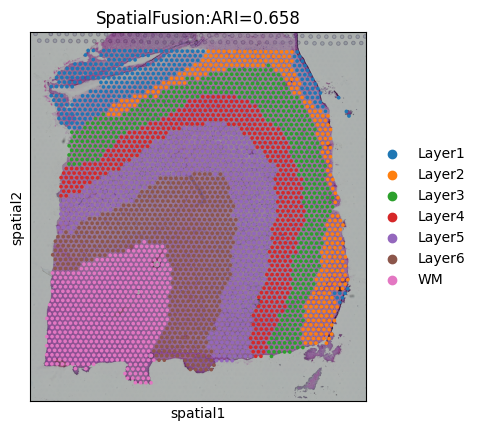

In [15]:
# plotting spatial clustering result
sc.pl.spatial(adata,
              img_key="hires",
              color=["domain"],
              title=["SpatialFusion:ARI=%.3f"%ARI],
              show=True)

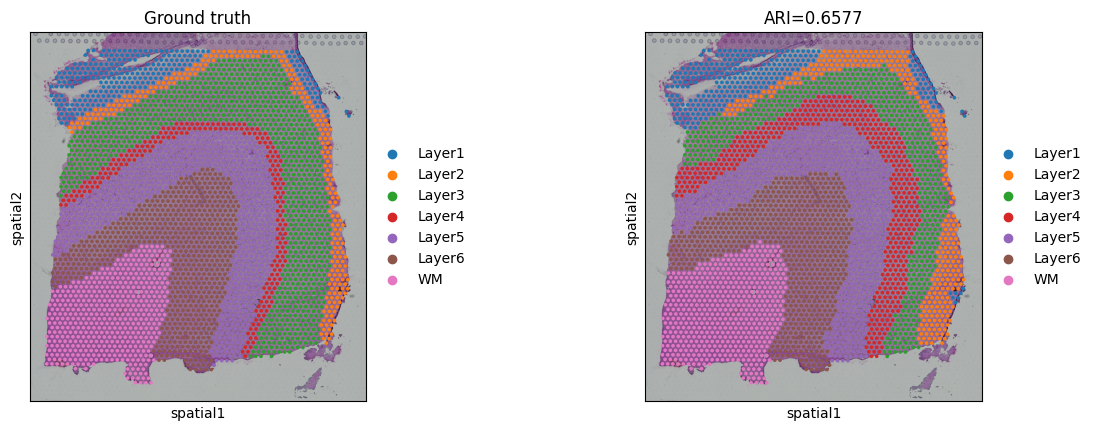

In [16]:
# plotting spatial clustering result
sc.pl.spatial(adata,
              img_key="hires",
              color=["ground_truth", "domain"],
              title=["Ground truth", "ARI=%.4f"%ARI],
              show=True)

<Axes: title={'center': 'SpatialFusion'}, xlabel='UMAP1', ylabel='UMAP2'>

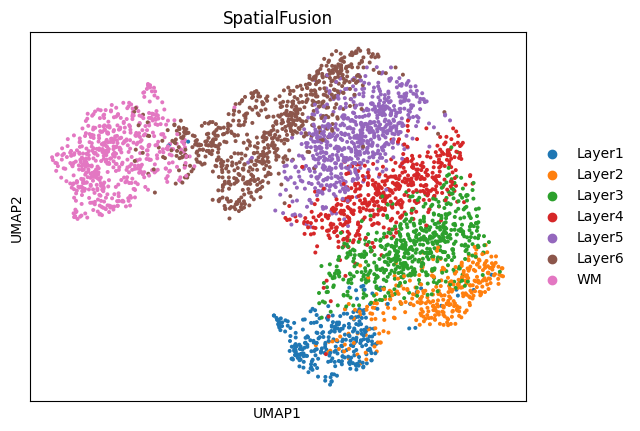

In [18]:
# plotting predicted labels by UMAP
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color='domain', title=['SpatialFusion'], show=False)

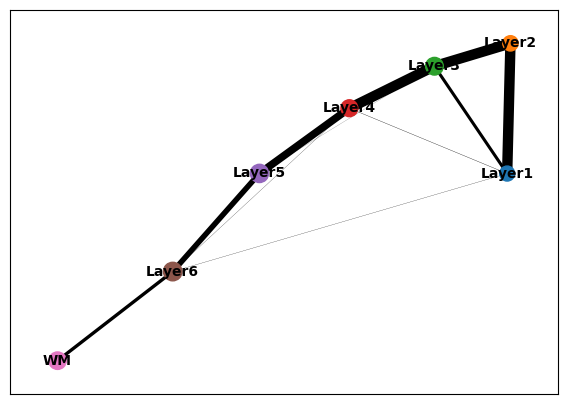

In [19]:
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.paga(adata, groups='domain')
sc.pl.paga(adata)

[<Axes: xlabel='UMAP1', ylabel='UMAP2'>, <Axes: >]

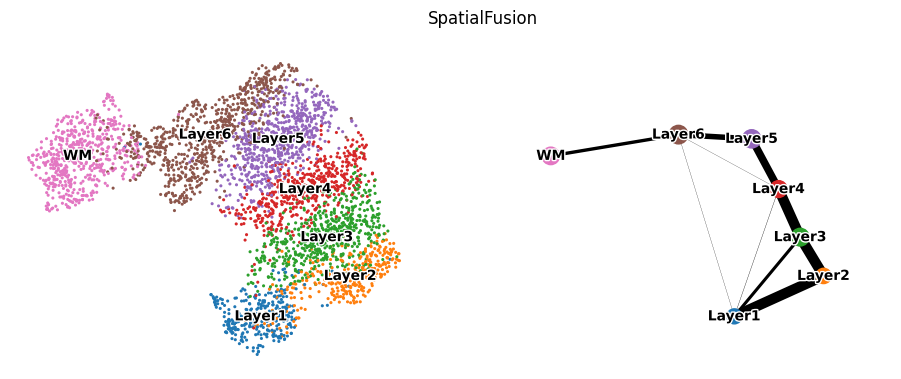

In [20]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (5,4)
# sc.pl.paga_compare(adata, legend_fontsize=10, frameon=False, size=20,
#                    title='VARGG', legend_fontoutline=2, show=False)
sc.pl.paga_compare(adata,legend_fontsize=10, frameon=False, size=20,
    threshold=0.01,legend_fontoutline=2,
    # 这个值可能需要根据你的具体情况进行调整
    show=False,title='SpatialFusion'
)
